In [112]:
# SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ', 'XXYY', 'XYYX', 'YXXY', 'YYXX'],
#               coeffs=[-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j,
#  -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j,
#   0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j, -0.04530262+0.j,
#   0.04530262+0.j,  0.04530262+0.j, -0.04530262+0.j])

In [113]:
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt

In [114]:
# from qiskit.quantum_info import SparsePauliOp
# from qiskit_aer import AerSimulator

obsv_list = [
    [SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])],
    [SparsePauliOp(['XXYY'], [-0.04530262+0.j])],
    [SparsePauliOp(['XYYX'], [ 0.04530262+0.j])],
    [SparsePauliOp(['YXXY'], [ 0.04530262+0.j])],
    [SparsePauliOp(['YYXX'], [-0.04530262+0.j])]
]

angles = [pi/2]

### Estimator

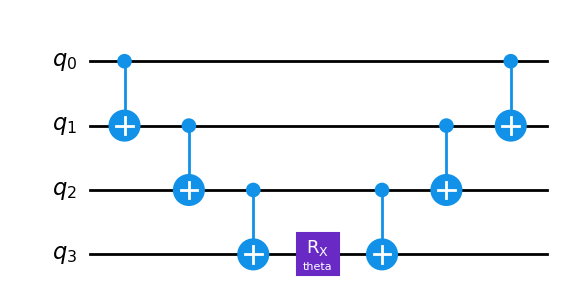

In [115]:
estimator = EstimatorV2(backend=AerSimulator())

theta = Parameter('theta')

qc = QuantumCircuit(4)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.rx(theta, 3)
qc.cx(2,3)
qc.cx(1,2)
qc.cx(0,1)
# qc.measure(qr, cr)
qc.draw(reverse_bits=False)

[[ 7.47883634e-02]
 [-1.08726288e-04]
 [ 8.15447160e-05]
 [-1.35907860e-04]
 [-6.79539300e-04]]
Mean: 0.014789146933199989


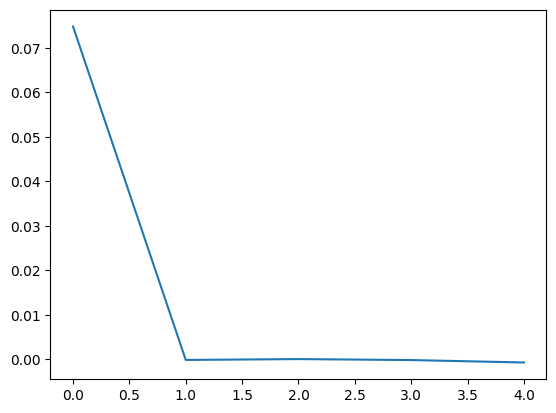

In [116]:
job = estimator.run([(qc, obsv_list, angles, 0.01)])
exp_vals = job.result()[0].data.evs
print(exp_vals)
print("Mean:", np.mean(exp_vals))
plt.plot(exp_vals)

### Sampler

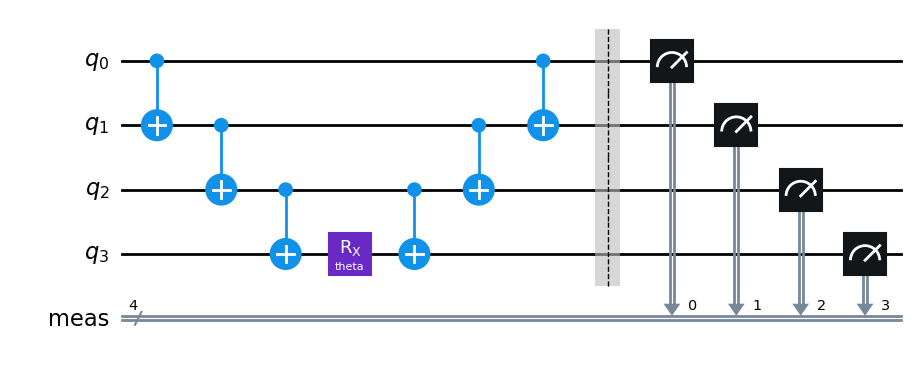

In [117]:
theta = Parameter('theta')

qc = QuantumCircuit(4)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.rx(theta, 3)
qc.cx(2,3)
qc.cx(1,2)
qc.cx(0,1)

# qc.measure(qr, cr)
qc.measure_all()
qc.draw(reverse_bits=False)

{'1000': 536, '0000': 488}


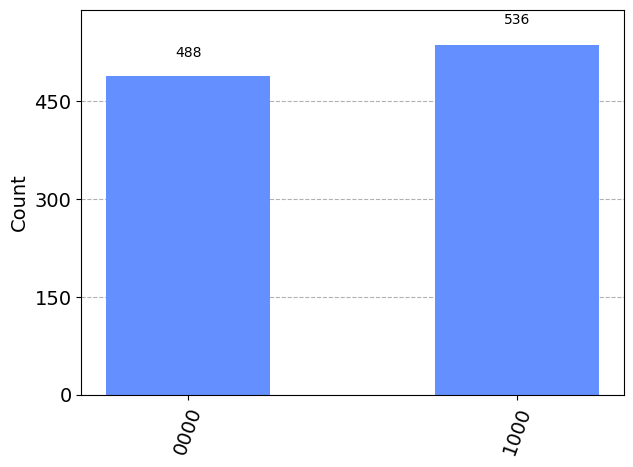

In [118]:
sampler = SamplerV2(backend=AerSimulator())
job = sampler.run([(qc, angles)])
counts = job.result()[0].data.meas.get_counts()
print(counts)
plot_histogram(counts)

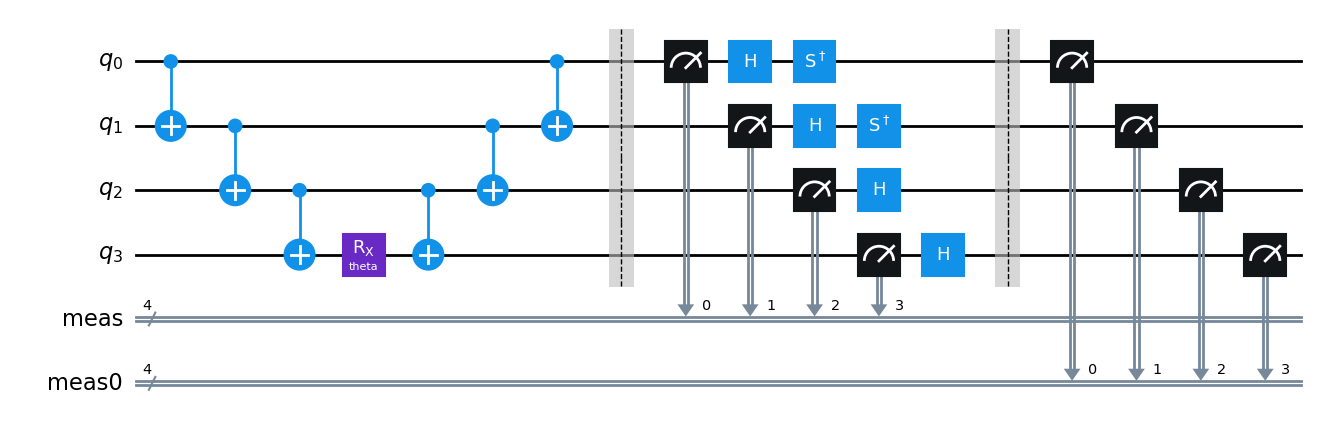

In [119]:
## YYXX Observables
theta = Parameter('theta')

qc_sampler = qc.copy()

qc_sampler.h(0)
qc_sampler.sdg(0)
qc_sampler.h(1)
qc_sampler.sdg(1)
qc_sampler.h(2)
qc_sampler.h(3)

# qc.measure(qr, cr)
qc_sampler.measure_all()
qc_sampler.draw(reverse_bits=False)

In [120]:
sampler = SamplerV2(backend=AerSimulator())
job = sampler.run([(qc_sampler, angles)], shots=10000)
counts = job.result()[0].data.meas.get_counts()
print("Counts:", counts)
plot_histogram(counts)



total_shots = sum(counts.values())
print("Total Shots:", total_shots)
probabilities = {state: count/total_shots for state, count in counts.items()}
print("probabilities:", probabilities)

# Measure the Expectation Value
exp_vals_sampler = 0

for state, prob in probabilities.items():
    state_bits = [ int(bit) for bit in state]
    parity = state_bits[0] ^ state_bits[1] ^ state_bits[2] ^ state_bits[3]
    print("State bits:", state_bits, "Parity:", parity)
    exp_vals_sampler += prob * (1 if parity == 0 else -1)

print(exp_vals_sampler)

Counts: {'1000': 5014, '0000': 4986}
Total Shots: 10000
probabilities: {'1000': 0.5014, '0000': 0.4986}
State bits: [1, 0, 0, 0] Parity: 1
State bits: [0, 0, 0, 0] Parity: 0
-0.002799999999999969


### Comparison

[[ 0.08168157]
 [ 0.00058893]
 [-0.00071578]
 [-0.00023557]
 [ 0.00047115]]
Mean: 0.01635805869519998
Counts: {'1000': 5060, '0000': 4940}
Total Shots: 10000
probabilities: {'1000': 0.506, '0000': 0.494}
State bits: [1, 0, 0, 0] Parity: 1
State bits: [0, 0, 0, 0] Parity: 0
Using Estimator: -0.000235573624
Using Sampler: 0.0005436000000000005
DIfference: -0.0007791736240000005


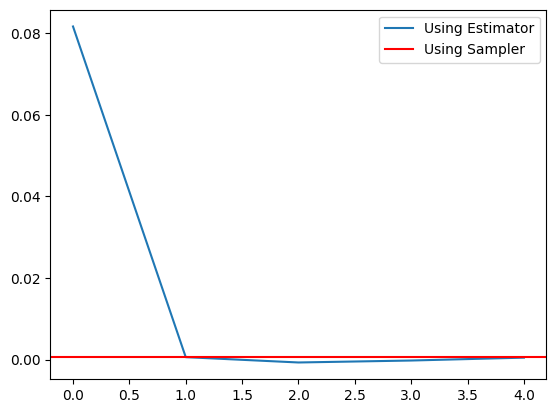

In [134]:
job = estimator.run([(qc, obsv_list, angles, 0.01)])
exp_vals = job.result()[0].data.evs
print(exp_vals)
print("Mean:", np.mean(exp_vals))

sampler = SamplerV2(backend=AerSimulator())
job = sampler.run([(qc_sampler, angles)], shots=10000)
counts = job.result()[0].data.meas.get_counts()
print("Counts:", counts)
plot_histogram(counts)



total_shots = sum(counts.values())
print("Total Shots:", total_shots)
probabilities = {state: count/total_shots for state, count in counts.items()}
print("probabilities:", probabilities)

# Measure the Expectation Value
exp_vals_sampler = 0

for state, prob in probabilities.items():
    state_bits = [ int(bit) for bit in state]
    parity = state_bits[0] ^ state_bits[1] ^ state_bits[2] ^ state_bits[3]
    print("State bits:", state_bits, "Parity:", parity)
    exp_vals_sampler += prob * (1 if parity == 0 else -1)

print("Using Estimator:",exp_vals[3][0])
print("Using Sampler:", exp_vals_sampler*-0.04530)
print("DIfference:", exp_vals[3][0]-exp_vals_sampler*-0.04530)

plt.plot(exp_vals, label='Using Estimator')
plt.axhline(y=exp_vals_sampler*-0.0453, color='r', label='Using Sampler')
plt.legend()
# plt.plot(4,exp_vals_sampler*-0.04530)

In [58]:
print(obsv_list)
print(exp_vals)
print(exp_vals_sampler*-0.04530)

[[SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j,
 -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j,
  0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])], [SparsePauliOp(['XXYY'],
              coeffs=[-0.04530262+0.j])], [SparsePauliOp(['XYYX'],
              coeffs=[0.04530262+0.j])], [SparsePauliOp(['YXXY'],
              coeffs=[0.04530262+0.j])], [SparsePauliOp(['YYXX'],
              coeffs=[-0.04530262+0.j])]]
[[ 0.08318554]
 [-0.00030806]
 [ 0.00061612]
 [-0.0003443 ]
 [ 0.00059799]]
3.623999999999946e-05


In [110]:
# from qiskit import QuantumCircuit, Aer, transpile
# from qiskit.circuit.library import HGate, SdgGate
# from qiskit.quantum_info import SparsePauliOp
# from qiskit.primitives import Sampler, Estimator

# Define the coefficient of the SparsePauliOp
coefficient = -0.04530262

# Create a 4-qubit quantum circuit
qc = QuantumCircuit(4)
backend = AerSimulator()

# Add your quantum gates here
# Example:
qc.h([0, 1, 2, 3])  # Initialize all qubits in superposition for example

# Define the observable YYXX
observable = SparsePauliOp.from_list([('YYXX', coefficient)])

# Calculate using Estimator
estimator = EstimatorV2(backend=backend)
job_estimator = estimator.run(qc, observable)
result_estimator = job_estimator.result()
expectation_value_estimator = result_estimator.values[0]

print("Expectation value using Estimator:", expectation_value_estimator)

# Apply H and Sdg gates to change the measurement basis for YYXX
qc_with_basis_change = qc.copy()
qc_with_basis_change.h([0,1,2,3])
qc_with_basis_change.sdg([0,1])


# Measure the qubits
qc_with_basis_change.measure_all()

# Transpile the circuit for the backend
qc_with_basis_change = transpile(qc_with_basis_change, backend)

# Run the circuit using the Sampler
sampler = SamplerV2(backend=backend)
result = sampler.run([qc_with_basis_change], shots=10000).result()

# Get the measurement results
counts = result.quasi_dists[0]

# Normalize counts to get probabilities
total_counts = sum(counts.values())
probabilities = {state: count / total_counts for state, count in counts.items()}

# Initialize the expectation value
expectation_value_sampler = 0

# Iterate through all possible states
for state, prob in probabilities.items():
    # Convert state from string to list of integers
    state_bits = [int(bit) for bit in reversed(state)]  # Qiskit returns state in little-endian format

    # Calculate the parity of the qubits (XOR operation)
    parity = state_bits[0] ^ state_bits[1] ^ state_bits[2] ^ state_bits[3]
    
    # Add to the expectation value (1 for even parity, -1 for odd parity)
    expectation_value_sampler += prob * (1 if parity == 0 else -1)

# Multiply by the coefficient
expectation_value_sampler *= coefficient

print("Expectation value using Sampler:", expectation_value_sampler)

# Compare the results
if abs(expectation_value_estimator - expectation_value_sampler) < 1e-6:
    print("The results match.")
else:
    print("The results do not match.")


TypeError: EstimatorV2.run() takes 2 positional arguments but 3 were given